In [ ]:
pip install findspark

In [ ]:
pip install pyspark

In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.sql("select 'spark' as hello_spark ")
df.show()

+-----------+
|hello_spark|
+-----------+
|      spark|
+-----------+



In [ ]:
spark

In [3]:
import pyspark.sql.functions as func
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import  (StringType,IntegerType,TimestampType)                               
from datetime import datetime
from pyspark.sql import functions as F 
from pyspark.sql.functions import col,udf

# Data Ingestion & Description:

In [4]:
sql_sc = SQLContext(spark)
repository='C:/Users/adam_/Desktop/Adam_Work_Spark/trips_spark/Shared_Micromobility_Vehicle_2019_Trips.csv'
Austin_Trips_Df = spark.read.csv(repository,header='True',inferSchema='true') 

In [ ]:
Austin_Trips_Df.count()

In [55]:
Austin_Trips_Df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Device ID: string (nullable = true)
 |-- Vehicle Type: string (nullable = true)
 |-- Trip_Duration(minutes): double (nullable = true)
 |-- Trip Distance: integer (nullable = true)
 |-- Start Time: timestamp (nullable = true)
 |-- End Time: timestamp (nullable = true)
 |-- Modified Date: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Day of Week: string (nullable = true)
 |-- Council District (Start): integer (nullable = true)
 |-- Council District (End): integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Census Tract Start: string (nullable = true)
 |-- Census Tract End: string (nullable = true)
 |-- Is_Weekend: string (nullable = true)



In [ ]:
Austin_Trips_Df.describe().show()

In [ ]:
Austin_Trips_Df.head(2)

# Data Cleansing & Transformations:

I start cleansing operation by running some basic Pyspark functions as shown below:

In [6]:
Austin_Trips_Df=Austin_Trips_Df.dropDuplicates()

In [ ]:
Austin_Trips_Df.dropna().count()

In [ ]:
Austin_Trips_Df.count()

I find out 24 duplicates rows.

In [5]:
Austin_Trips_Df=Austin_Trips_Df.dropna()

I decide to remove non used-columns such as Year and modified date

In [7]:
To_TS=  udf(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'), TimestampType())
Austin_Trips_Df= Austin_Trips_Df.withColumn('Start Time', To_TS(col('Start Time'))).withColumn('End Time',To_TS(col('End Time')))

Timestamp difference in Spark can be calculated by casting timestamp column to LongType and by subtracting two long values results in second differences, dividing by 60 results in minute difference 

In [8]:
timepattern = "yyyy-MM-dd'T'HH:mm:ss"
timeDiff = (F.unix_timestamp(Austin_Trips_Df['End Time'], format=timepattern)
        - F.unix_timestamp(Austin_Trips_Df['Start Time'], format=timepattern))
Austin_Trips_Df= Austin_Trips_Df.withColumn('Trip Duration', timeDiff)
#convert seconds to minute and round the seconds for further use. 
Austin_Trips_Df= Austin_Trips_Df.withColumn('Trip Duration',func.round(Austin_Trips_Df['Trip Duration']/ 60.0)).withColumnRenamed('Trip Duration','Trip_Duration(minutes)')

In [ ]:
Austin_Trips_Df.select("Trip_Duration(minutes)").describe().show()

In [9]:
Austin_Trips_Df=Austin_Trips_Df.filter(Austin_Trips_Df['Trip_Duration(minutes)']>=0)

In [ ]:
Austin_Trips_Df.count() #2198461 before transformation

In [10]:
day = {"1": "MON", "2": "TUE", "3": "WED", "4": "THU", "5": "FRI", "6": "SAT", "0": "SUN"}
day = {k:str(v) for k,v in zip(day.keys(),day.values())}
Austin_Trips_Df= Austin_Trips_Df.withColumn('Day of Week', Austin_Trips_Df['Day of Week'].cast("string"))
Austin_Trips_Df = Austin_Trips_Df.na.replace(day,1,"Day of Week")

C:\Users\adam_\Anaconda3\lib\site-packages\pyspark\sql\dataframe.py:1794: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


In [11]:
WE_func =  udf (lambda x: True if x in('SAT','SUN') else False)
Austin_Trips_Df= Austin_Trips_Df.withColumn('Is_Weekend',WE_func(Austin_Trips_Df['Day of Week']))

Checking the new schema as result of our previous operations 

In [56]:
Austin_Trips_Df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Device ID: string (nullable = true)
 |-- Vehicle Type: string (nullable = true)
 |-- Trip_Duration(minutes): double (nullable = true)
 |-- Trip Distance: integer (nullable = true)
 |-- Start Time: timestamp (nullable = true)
 |-- End Time: timestamp (nullable = true)
 |-- Modified Date: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Day of Week: string (nullable = true)
 |-- Council District (Start): integer (nullable = true)
 |-- Council District (End): integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Census Tract Start: string (nullable = true)
 |-- Census Tract End: string (nullable = true)
 |-- Is_Weekend: string (nullable = true)



#Statistical analysis

In [ ]:
Austin_Trips_Df.groupBy("Day of Week").count().sort("count",ascending=True).show()

In [ ]:
Austin_Trips_Df.groupBy("Month").count().sort("count",ascending=True).show()

In [ ]:
Austin_Trips_Df.crosstab('Vehicle Type', 'Month').sort("Vehicle Type_Month",ascending=True).show()

In [47]:
Austin_Trips_Df.crosstab('Day of Week', 'Month').sort("Day of Week_Month",ascending=True).show()

+-----------------+-----+-----+-----+---+-----+-----+-----+-----+-----+-----+-----+-----+
|Day of Week_Month|    1|   10|   11| 12|    2|    3|    4|    5|    6|    7|    8|    9|
+-----------------+-----+-----+-----+---+-----+-----+-----+-----+-----+-----+-----+-----+
|              FRI|19630|31640|17789|  0|21506|67774|40988|38575|31360|33578|34989|32118|
|              MON|15006|18607|12900|  0|16292|30053|28599|26062|19190|19578|15121|23419|
|              SAT|33134|48337|36307|  0|35306|87672|46074|50671|52306|44511|53322|57855|
|              SUN|25266|36754|21823|413|30258|61874|36897|45605|34702|29481|25278|38982|
|              THU|17452|21969| 8472|  0|14178|45861|24912|27600|20729|28746|23063|20354|
|              TUE|16939|17562|10263|  0|13304|33726|25210|18612|16961|20521|15455|16732|
|              WED|11658|17357| 9846|  0|16402|36730|16096|25713|20626|22697|17688|17311|
+-----------------+-----+-----+-----+---+-----+-----+-----+-----+-----+-----+-----+-----+



In [ ]:
Austin_Trips_Df=Austin_Trips_Df.withColumn('Cost($)',(Austin_Trips_Df['Trip_Duration(minutes)']*0.15+1))

In [ ]:
Austin_Trips_Df.describe(['Cost($)']).show()

In [ ]:
Austin_Trips_Df.head(2)

#Data_viz

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
count = [item[1] for item in Austin_Trips_Df.groupBy("Hour").count().sort("count",ascending=True).collect()]
Hour = [item[0] for item in Austin_Trips_Df.groupBy("Hour").count().collect()]
Hour_Breakdown = {"count":count, "Hour" : Hour}
Hour_Breakdown = pd.DataFrame(Hour_Breakdown)
Hour_Breakdown = Hour_Breakdown.sort_values(by = "count", ascending  = False)

In [ ]:
Hour_Breakdown.info()

In [ ]:
Usage_per_Hour = Hour_Breakdown.sort_values(by = "Hour")
Usage_per_Hour.plot(figsize = (15,7), kind = "line", x = "Hour", y = "count",color = "g", linewidth =5, legend = False)
plt.xlabel("Hour", fontsize = 18)
plt.ylabel("Usage Rate", fontsize = 18)
plt.title("Usage_Per_Hour_Breakdown", fontsize = 28)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

In [ ]:
count = [item[1] for item in Austin_Trips_Df.groupBy("Day of Week").count().sort("count",ascending=True).collect()]
Day_Of_Week = [item[0] for item in Austin_Trips_Df.groupBy("Day of Week").count().collect()]
DayOfWeek_Breakdown = {"count":count, "Day_Of_Week" : Day_Of_Week}
DayOfWeek_Breakdown = pd.DataFrame(DayOfWeek_Breakdown)

In [ ]:
DayOfWeek_Breakdown  = DayOfWeek_Breakdown .sort_values(by = "Day_Of_Week")
DayOfWeek_Breakdown.plot(figsize = (15,7), kind = "bar", color = "green",x = "Day_Of_Week", y = "count", legend = False)
plt.xlabel("", fontsize = 18)
plt.ylabel("Usage rate", fontsize = 18)
plt.title("Usage_Per_Day_Of_Week_Breakdown", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

In [48]:
count = [item[1] for item in Austin_Trips_Df.groupBy("Month").count().sort("count",ascending=True).collect()]
Month = [item[0] for item in Austin_Trips_Df.groupBy("Month").count().collect()]
Month_Breakdown = {"count":count, "Month" : Month}
Month_Breakdown = pd.DataFrame(Month_Breakdown)

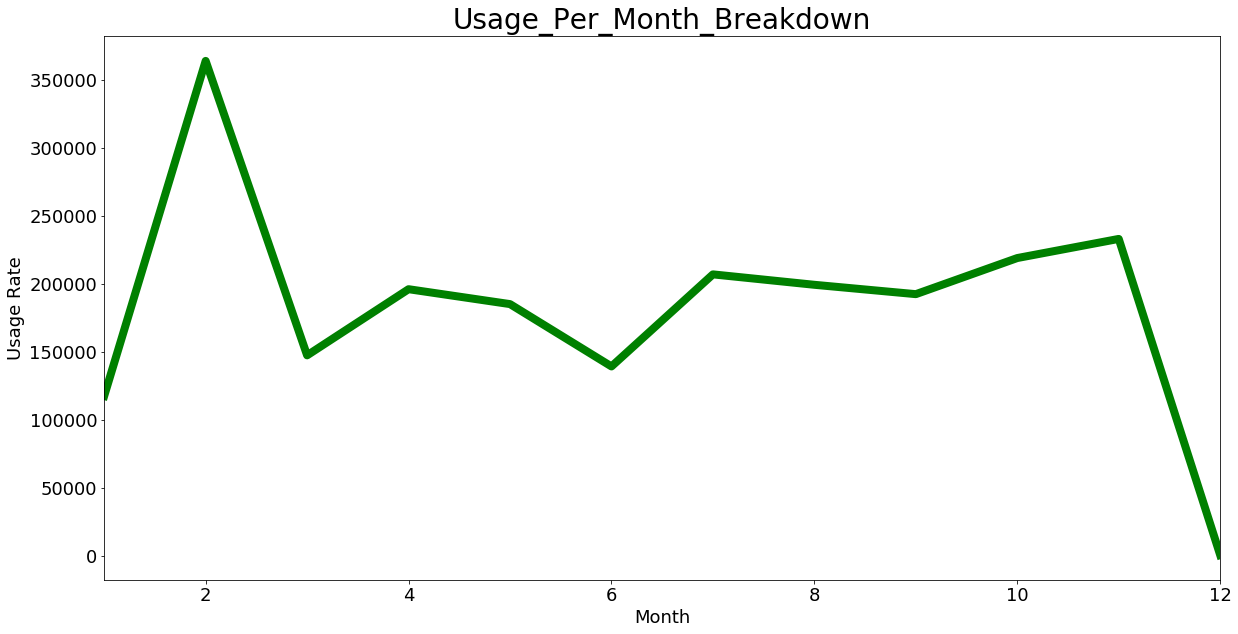

In [49]:
Uses_per_month = Month_Breakdown.sort_values(by = "Month")
Uses_per_month.plot(figsize = (20,10), kind = "line", x = "Month", y = "count", 
                      color = "green", linewidth = 8, legend = False)
plt.xlabel("Month", fontsize = 18)
plt.ylabel("Usage Rate", fontsize = 18)
plt.title("Usage_Per_Month_Breakdown", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

In [63]:
count = [item[1] for item in Austin_Trips_Df.groupBy("Vehicle Type").count().sort("count",ascending=True).collect()]
Vehicle_Type = [item[0] for item in Austin_Trips_Df.groupBy("Vehicle Type").count().collect()]
Vehicle_Type_Breakdown = {"count":count, "Vehicle Type" : Vehicle_Type}
Vehicle_Type_Breakdown = pd.DataFrame(Vehicle_Type_Breakdown)
Vehicle_Type_Breakdown = Vehicle_Type_Breakdown.sort_values(by = "count", ascending  = False)
Vehicle_Type_Breakdown.iloc[:2]

,count,Vehicle Type
1,2014885,bicycle
0,183462,scooter


In [ ]:
Vehicle_Type_Breakdown = Vehicle_Type_Breakdown.iloc[:2]
myplot = Vehicle_Type_Breakdown.plot(figsize = (8,8), kind = "barh", color = "green", width = 0.4,
                               x = "Vehicle Type", y = "count", legend = False)
myplot.invert_yaxis()
plt.xlabel("Usage Rate", fontsize = 15)
plt.ylabel("Vehicle_Type", fontsize = 15)
plt.title("Usage_Per_Vehicle_Type_Breakdown", fontsize = 25)
plt.xticks(size = 10)
plt.yticks(size = 15)
plt.show()

In [34]:
temp = Austin_Trips_Df.select("Day of Week","Hour")
hourlyCount  = temp.groupBy(["Day of Week","Hour"]).count().sort("Day of Week",ascending=True).collect()
days = [item[0] for item in hourlyCount]
hours = [item[1] for item in hourlyCount]
count = [item[2] for item in hourlyCount]
usage_byHour = {"count": count, "hours": hours, "days": days}
usage_byHour = pd.DataFrame(usage_byHour)
usage_byHour = usage_byHour.sort_values(by = "hours", ascending  = True)

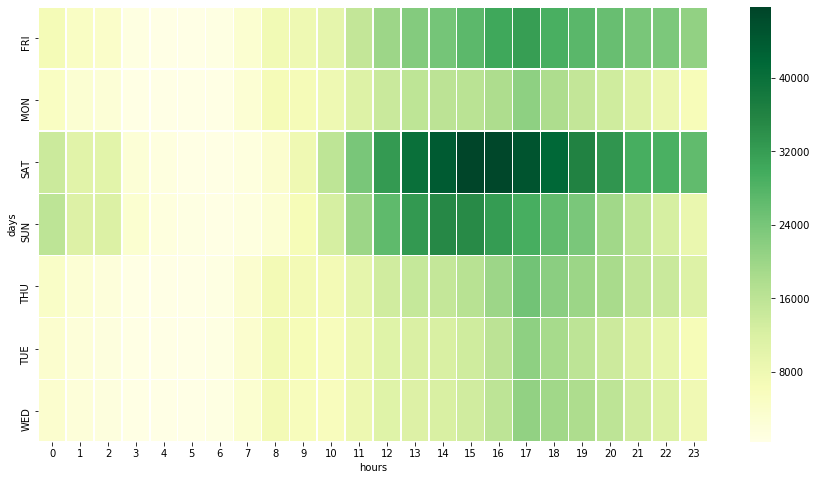

In [40]:
plt.figure(figsize = (15,8))
usage = usage_byHour.pivot("days", "hours", "count")
ax = sns.heatmap(usage,cmap="YlGn",linewidths=.5)

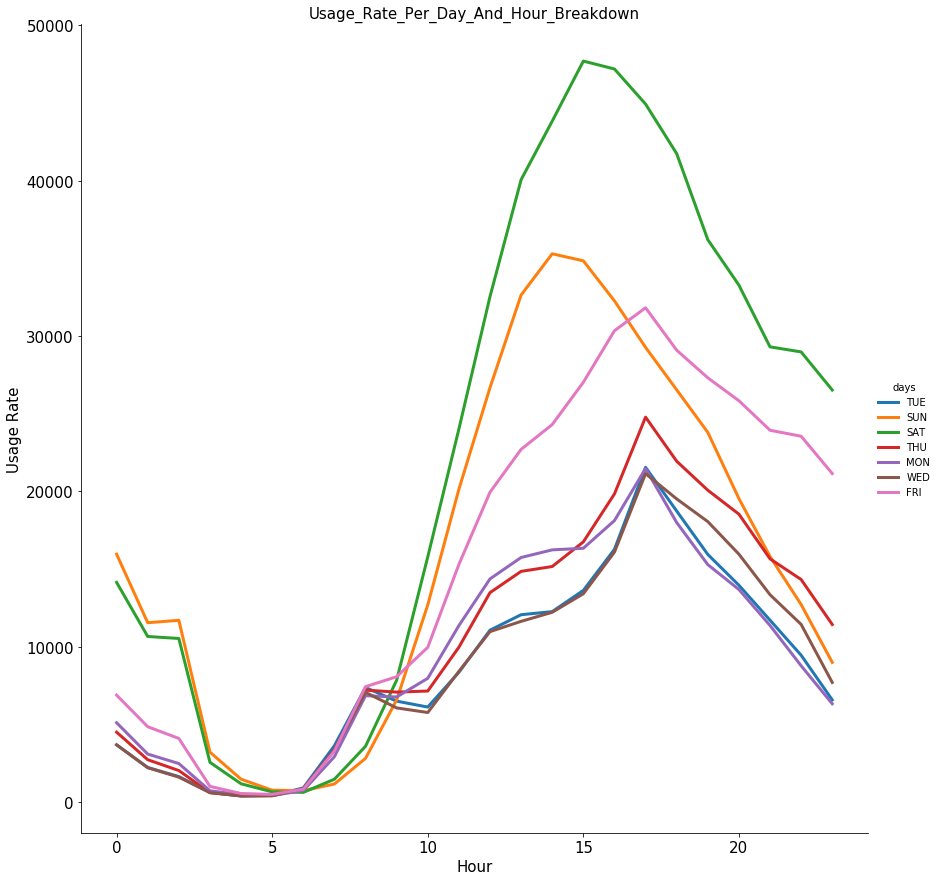

In [23]:
DH = sns.FacetGrid(usage_byHour, hue="days", size = 12)
DH.map(plt.plot, "hours", "count", linewidth = 3)
DH.add_legend()
plt.ylabel("Usage Rate", fontsize = 15)
plt.xlabel("Hour", fontsize = 15)
plt.title("Usage_Rate_Per_Day_And_Hour_Breakdown", fontsize = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

In [61]:
tmp = Austin_Trips_Df.select("Day of Week","Month")
monthlyCount  = tmp.groupBy(["Day of Week","Month"]).count().collect()
days = [item[0] for item in monthlyCount]
months = [item[1] for item in monthlyCount]
count = [item[2] for item in monthlyCount]
usage_bymonth = {"count": count, "months": months, "days": days}
usage_bymonth = pd.DataFrame(usage_bymonth)
#usage_bymonth = pd.DataFrame.from_dict(usage_bymonth, orient='index')
usage_bymonth = usage_bymonth.sort_values(by = "months", ascending  = True)

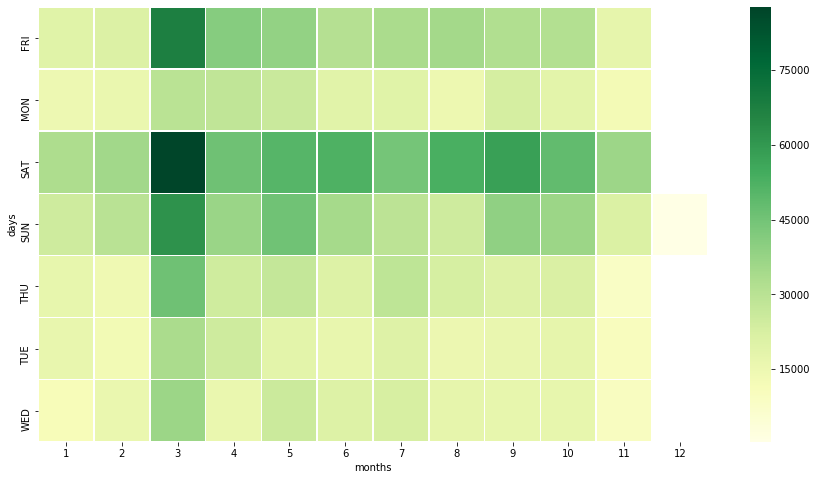

In [62]:
plt.figure(figsize = (15,8))
usage = usage_bymonth.pivot("days", "months", "count")
ax = sns.heatmap(usage,cmap="YlGn",linewidths=.5)